# Reinforcement learning algorithms for Tic-Tac-Toe

The class State is used to represent a configuration of the game

In [22]:
import pickle
import random
import numpy as np
from math import log, sqrt

SIZE = 3

class State(object):
    def __init__(self):
        # @data is a SIZE * SIZE array where
        # 0 represents an empty position
        # 1 represents a cross (symbol for player 1)
        # 2 represents a circle (symbol for player 2)
        self.data = np.zeros((SIZE, SIZE))
        # @player: who's turn it is to play from this state
        self.player = 1
        self.hash = 0
        # @outcome can be
        # 1 if Player 1 wins
        # 0 if Player 2 wins
        # 0.5 if it's a tie
        # -1 if the game is not over
        # 2 if the outcome has never been computed
        self.outcome = 2

    # Checks whether the game is over from this state and who won
    def compute_outcome(self):
        if self.outcome != 2:
            return self.outcome
        else:
            # Checks rows
            for i in range(0, SIZE):
                if all(x == 1 for x in self.data[i, :]):
                    self.outcome = 1
                    return 1
                if all(x == 2 for x in self.data[i, :]):
                    self.outcome = 0
                    return 0

            # Checks columns
            for j in range(0, SIZE):
                if all(x == 1 for x in self.data[:, j]):
                    self.outcome = 1
                    return 1
                if all(x == 2 for x in self.data[:, j]):
                    self.outcome = 0
                    return 0

            # Checks diagonals
            diag = [self.data[i,i] for i in range(0, SIZE)]
            if all(x == 1 for x in diag):
                self.outcome = 1
                return 1
            if all(x == 2 for x in diag):
                self.outcome = 0
                return 0

            anti_diag = [self.data[i,SIZE - 1 - i] for i in range(0, SIZE)]
            if all(x == 1 for x in anti_diag):
                self.outcome = 1
                return 1
            if all(x == 2 for x in anti_diag):
                self.outcome = 0
                return 0

            # Checks whether it's a tie
            data_all = [self.data[i,j] for i in range(0, SIZE) for j in range(0, SIZE)]
            if all(x != 0 for x in data_all):
                self.outcome = 0.5
                return 0.5

            # If we reached this point the game is still going on
            self.outcome = -1
            return -1

    # Prints the board
    def print_state(self):
        for i in range(0, SIZE):
            print('-------------')
            out = '| '
            for j in range(0, SIZE):
                if self.data[i, j] == 1:
                    token = 'x'
                elif self.data[i, j] == 2:
                    token = 'o'
                else:
                    token = ' '
                out += token + ' | '
            print(out)
        print('-------------')

    # Takes a state and returns the full list of moves that are legal moves
    def legal_plays(self):
        legal = []
        for i in range(0, SIZE):
            for j in range(0, SIZE):
                if self.data[i, j] == 0:
                    legal.append((i,j))
        return legal

    # Actually not useful because hashes are computed recursively
    def compute_hash(self):
        self.hash = 0
        for i in self.data.reshape(SIZE * SIZE):
            self.hash = self.hash * 3 + i
        return self.hash

    # Compute the hash of the state obtained by playing in (i,j)
    def update_hash(self, i, j):
        return self.hash + 3 ** (SIZE * i + j) * self.player

    # Returns a new state obtained by playing in (i,j)
    def next_state(self, i, j):
        new_state = State()
        new_state.data = np.copy(self.data)
        new_state.data[i, j] = self.player
        new_state.hash = self.update_hash(i,j)
        new_state.player = 3 - self.player
        return new_state

    # Updates the same state by playing in (i,j)
    def update_state(self, i, j):
        self.data[i, j] = self.player
        self.hash = self.update_hash(i,j)
        self.player = 3 - self.player
        self.outcome = 2

The class Player implements the different algorithms for constructing a strategy.

There are two main choices:
* what strategy is used during training: 'epsilon-greedy' or 'UCB'
* how do we update estimates: 'average' or 'step_size' or 'TD'

### Strategies
The **epsilon-greedy** strategy plays at random with probability epsilon, and maximises or minimises the current value otherwise.

The **UCB (Upper Confidence Bound)** strategy uses the UCB formula which induces a tradeoff between exploration and exploitation. From a state if all available moves have been explored the strategy chooses the move which maximises or minimises the sum of two terms, one being the current value and the other one indicating how precise is the current value estimate. 
The parameter 'UCB' controls the exploitation.

### Estimates updates
The **average** update simply computes for a state the average over all plays containing this state of the outcomes.

The **step_size** update changes the value using a step size instead.

The **TD (Temporal Difference)** update values locally based on the current value estimates of the next state.

In [23]:
class Player():
    def __init__(self, name = '', strategy ='epsilon-greedy', update_mode = 'average',
                 epsilon = 0.25, UCB = 1.4, step_size = 0.1, exponent = 0):
        self.values = dict()
        self.name = name
        # @plays counts for each state how many plays included this state
        self.plays = dict()

        # What strategy are we using during training: 'epsilon-greedy' or 'UCB'
        self.strategy = strategy

        # How do we update estimates: 'average' or 'step_size' or 'TD'
        self.update_mode = update_mode

        # Parameters
        self.epsilon = epsilon
        self.UCB = UCB
        self.step_size = step_size
        self.exponent = exponent

    # Takes the state and returns the move to be applied
    def play(self, state, verbose = False):
        if not state.hash in self.values:
            if verbose:
                print("The player had never seen that state!")
            return random.choice(state.legal_plays())
        else:
            if verbose:
                print("%s player's turn as player %d.\nCurrent value: %0.5f"  % (self.name, state.player, self.values[state.hash]))
                print("Available moves and their values:")
                print([((i,j),self.values[state.update_hash(i,j)]) for (i,j) in state.legal_plays()
                       if state.update_hash(i,j) in self.values])

            # For more fun, we randomise over the most interesting moves
            if state.player == 1:
                evaluated_moves = [(self.values[state.update_hash(i,j)], (i,j)) for (i, j) in state.legal_plays()
                                   if state.update_hash(i,j) in self.values]
                max_val, _ = max(evaluated_moves)
                interesting_moves = [(i, j) for (v,(i, j)) in evaluated_moves if v == max_val]
            else:
                evaluated_moves = [(self.values[state.update_hash(i,j)], (i,j)) for (i, j) in state.legal_plays()
                                   if state.update_hash(i,j) in self.values]
                min_val, _ = min(evaluated_moves)
                interesting_moves = [(i, j) for (v,(i, j)) in evaluated_moves if v == min_val]
            return random.choice(interesting_moves)

    # Computes the (exact) values recursively
    def solve(self, state = State()):
        if state.compute_outcome() != -1:
            self.values[state.hash] = state.outcome
        else:
            if state.player == 1:
                current_val = 0
                for (i,j) in state.legal_plays():
                    next = state.next_state(i,j)
                    if not (next.hash in self.values):
                        self.solve(next)
                    current_val = max(current_val,self.values[next.hash])
                self.values[state.hash] = current_val
            else:
                current_val = 1
                for (i,j) in state.legal_plays():
                    next = state.next_state(i,j)
                    if not (next.hash in self.values):
                        self.solve(next)
                    current_val = min(current_val,self.values[next.hash])
                self.values[state.hash] = current_val

    # During training, takes the current state and returns the move to be applied
    def play_during_training(self, state, t):
        if self.strategy == 'epsilon-greedy':
            # Play the epsilon-greedy strategy
            if random.random() < self.epsilon / (t ** self.exponent):
                return (False,random.choice(state.legal_plays()))
            else:
                possible_states = [((i, j), state.update_hash(i, j)) for (i, j) in state.legal_plays()]
                if all(hash_val in self.plays for ((i, j), hash_val) in possible_states):
                    # If we have seen all of the legal moves at least once, we use the value
                    if state.player == 1:
                        _, (i, j) = max((self.values[hash_val], (i, j)) for ((i, j), hash_val) in possible_states)
                    else:
                        _, (i, j) = min((self.values[hash_val], (i, j)) for ((i, j), hash_val) in possible_states)
                else:
                    # Otherwise choose randomly among unevaluated moves
                    unevaluated_moves = [(i, j) for (i, j) in state.legal_plays() if
                                         not state.update_hash(i,j) in self.values]
                    (i, j) = random.choice(unevaluated_moves)
                return (True,(i,j))
        if self.strategy == 'UCB':
            # Play the UCB strategy
            possible_states = [((i, j), state.update_hash(i,j)) for (i, j) in state.legal_plays()]
            if all(hash_val in self.plays for ((i, j), hash_val) in possible_states):
                # If we have seen all of the legal moves at least once, we use the UCB bound
                if state.player == 1:
                    _, (i, j) = max(
                        (self.values[hash_val] +
                         self.UCB * sqrt(log(self.plays[state.hash]) / self.plays[hash_val]), (i, j))
                        for ((i, j), hash_val) in possible_states)
                else:
                    _, (i, j) = min(
                        (self.values[hash_val] -
                         self.UCB * sqrt(log(self.plays[state.hash]) / self.plays[hash_val]), (i, j))
                        for ((i, j), hash_val) in possible_states)
            else:
                # Otherwise choose randomly among unevaluated moves
                unevaluated_moves = [(i, j) for (i, j) in state.legal_plays() if
                                     not state.update_hash(i,j) in self.plays]
                (i, j) = random.choice(unevaluated_moves)
            return (True, (i, j))

    def store_new_state(self, state):
        if not(state.hash in self.plays):
            self.plays[state.hash] = 0
            self.values[state.hash] = 0

    def run_simulation(self, t):
        state = State()
        state.hash = 0
        self.store_new_state(state)
        self.plays[state.hash] += 1

        # We store the play in a sequence
        play = []

        while state.compute_outcome() == -1:
            greedy, (i, j) = self.play_during_training(state,t)
            play.append((greedy,state.hash))
            state.update_state(i, j)
            self.store_new_state(state)
            self.plays[state.hash] += 1

        if self.update_mode == 'average':
            # Update using average
            self.values[state.hash] = state.outcome
            for greedy,hash_val in play:
                self.values[hash_val] += 1.0 / self.plays[state.hash] * (state.outcome - self.values[hash_val])

        if self.update_mode == 'step_size':
            # Update using step size
            self.values[state.hash] = state.outcome
            for greedy,hash_val in play:
                self.values[hash_val] += self.step_size * (state.outcome - self.values[hash_val])

        if self.update_mode == 'TD':
            # Update using temporal difference (TD)
            next_hash_val = state.hash
            self.values[next_hash_val] = state.outcome
            for greedy,hash_val in reversed(play):
                if greedy:
                    td_error = self.values[next_hash_val] - self.values[hash_val]
                    self.values[hash_val] += self.step_size * td_error
                next_hash_val = hash_val

    def train(self, number_simulations, verbose = False):
        if verbose:
            print("Start training of Player %s" % self.name)
        for t in range(1,number_simulations+1):
            self.run_simulation(t)
            if verbose and t % 100 == 0:
                print("After %d iterations the value of the initial state is %0.5f" % (t, self.values[0]))

# Tests

The class Competition is used to play strategies against each other

In [24]:
class Competition(object):
    # Saves the value function
    def save_values(self, name, player):
        with open('strategy_%s.bin' % name, 'wb') as f:
            pickle.dump(player.values, f)

    # Loads a value function
    def load_values(self, name, player):
        with open('strategy_%s.bin' % name, 'rb') as f:
            player.values = pickle.load(f)

    # Takes two strategies (one for each player), play them against each other once and declare an outcome
    def play(self, player1, player2, verbose=False):
        state = State()
        state.hash = 0

        if verbose:
            print("Match between Player %s (as Player 1) and Player %s (as Player 2)" % (player1.name, player2.name)) 

        while state.compute_outcome() == -1:
            if verbose:
                state.print_state()
            if state.player == 1:
                i, j = player1.play(state, verbose)
                state.update_state(i, j)
                if verbose:
                    print("Player %d chooses (%d,%d)" % (1, i, j))
            else:
                i, j = player2.play(state, verbose)
                state.update_state(i, j)
                if verbose:
                    print("Player %d chooses (%d,%d)" % (2, i, j))

        if verbose:
            print("Final state")
            state.print_state()
            if state.outcome == 1:
                print("Player 1 won")
            elif state.outcome == 0:
                print("Player 2 won")
            else:
                print("It's a tie!")
        return state.outcome

    # Takes two strategies (one for each player) and play them against each other for a number of games
    def compete(self, player1, player2, games = 500):
        player1_win = 0.0
        player2_win = 0.0
        for _ in range(games):
            outcome = self.play(player1,player2)
            if outcome == 1:
                player1_win += 1
            if outcome == 0:
                player2_win += 1
        print("Competition results: %d plays, player 1 wins %.02f, player 2 wins %.02f" % (games, player1_win / games, player2_win / games))

    # Checks whether a player ensures ties against another player over a number of games
    def ensures_tie(self, player1, player2, games = 50, player_of_interest = 1):
        i = 0
        while i < games:
            if self.play(player1,player2) == player_of_interest - 1:
                return i
            i += 1
        return games

We instantiate all the players (with default parameters).
For convenience the value functions are loaded to avoid training each of them again.
Uncomment for training them again and saving the value functions.

In [25]:
competition = Competition()

player_optimal = Player()
player_optimal.solve()
#competition.save_values("optimal", player_optimal)
competition.load_values("optimal", player_optimal)

player_eps_average = Player(name='epsilon-greedy average sample', strategy='epsilon-greedy', update_mode='average')
player_eps_step_size = Player(name='epsilon-greedy step size', strategy='epsilon-greedy', update_mode='step_size')
player_eps_td = Player(name='epsilon-greedy TD', strategy='epsilon-greedy', update_mode='TD')

player_UCB_average = Player(name='UCB average sample', strategy='UCB', update_mode='average')
player_UCB_step_size = Player(name='UCB step size', strategy='UCB', update_mode='step_size')
player_UCB_td = Player(name='UCB TD', strategy='UCB', update_mode='TD')

player_eps_td.train(5000, True)
competition.compete(player_eps_td,player_optimal)

Start training of Player epsilon-greedy TD
After 100 iterations the value of the initial state is 0.00007
After 200 iterations the value of the initial state is 0.00151
After 300 iterations the value of the initial state is 0.00503
After 400 iterations the value of the initial state is 0.00672
After 500 iterations the value of the initial state is 0.01012
After 600 iterations the value of the initial state is 0.00759
After 700 iterations the value of the initial state is 0.01188
After 800 iterations the value of the initial state is 0.00690
After 900 iterations the value of the initial state is 0.00494
After 1000 iterations the value of the initial state is 0.00278
After 1100 iterations the value of the initial state is 0.00232
After 1200 iterations the value of the initial state is 0.00525
After 1300 iterations the value of the initial state is 0.00219
After 1400 iterations the value of the initial state is 0.00737
After 1500 iterations the value of the initial state is 0.01426
After 

## How many iterations to ensure a tie against the optimal player?

In [26]:
def how_many_iterations(player,steps = 100, games = 500, verbose = False, player_of_interest = 1):
    iteration = 0
    while(True):
        player.train(steps)
        iteration += steps
        if player_of_interest == 1:
            result = competition.ensures_tie(player,player_optimal,games,player_of_interest)
        else:
            result = competition.ensures_tie(player_optimal,player,games,player_of_interest)
        if result == games:
            if verbose:
                print("After %d iterations, Player %s ensured ties each of the %d matches"
                      % (iteration, player.name,games))
            return iteration
        elif verbose:
            print("After %d iterations, Player %s lost the match number %d" % (iteration, player.name, result))

#how_many_iterations(player_eps_average, steps = 1000, games = 100, verbose = False)
#how_many_iterations(player_eps_step_size, steps = 1000, games = 100, verbose = False)
#how_many_iterations(player_eps_td, steps = 1000, games = 100, verbose = False)

#how_many_iterations(player_UCB_average, steps = 1000, games = 100, verbose = False)
#how_many_iterations(player_UCB_step_size, steps = 1000, games = 100, verbose = False)
how_many_iterations(player_UCB_td, steps = 1000, games = 100, verbose = False)

8000

## Parameter tuning

We explore the influence of the different parameters for each of the players.
Running the statistics takes a long time since we train a lot of players!

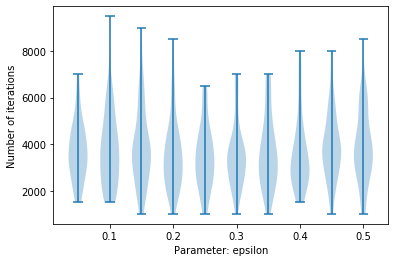

In [27]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

def run_statistics(strategy, update_mode, parameter_name, parameter_list, number_tests, steps, games):
    out = [[] for i in range(len(parameter_list))]
    for index,parameter in enumerate(parameter_list):
        print("parameter: %0.2f" % parameter)
        for i in tqdm(range(number_tests)):
            if parameter_name == 'epsilon':
                player = Player(strategy=strategy, update_mode=update_mode, epsilon=parameter)
            if parameter_name == 'UCB':
                player = Player(strategy=strategy, update_mode=update_mode, UCB=parameter)
            if parameter_name == 'step_size':
                player = Player(strategy=strategy, update_mode=update_mode, step_size=parameter)
            out[index].append(how_many_iterations(player,steps,games,verbose=False))
    with open('statistics_%s_%s.bin' % (strategy, update_mode), 'wb') as f:
        pickle.dump(out, f)
    return(out)

parameter_list_eps_td = [(i + 1) / 20 for i in range(10)]
parameter_list_ucb_td = [1 + (i + 1) / 10 for i in range(10)]

#run_statistics(strategy='UCB', update_mode='TD', parameter_name = 'epsilon', parameter_list = parameter_list_ucb_td,
#               number_tests = 50, steps = 250, games = 50)

def print_statistics(name_file, parameter_list, name_parameters):
    with open('%s.bin' % name_file, 'rb') as f:
        out = pickle.load(f)
    fig, ax = plt.subplots()
    ax.violinplot(out,parameter_list,widths=0.03)
    ax.set_xlabel("Parameter: %s" %name_parameters)
    ax.set_ylabel("Number of iterations")
    plt.savefig('%s.png' % name_file)
    plt.show()
    plt.close()

print_statistics(name_file='statistics_epsilon-greedy_TD', parameter_list=parameter_list_eps_td,
                 name_parameters='epsilon')